In [1]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 
import matplotlib.ticker as ticker
import math

from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("Output/data_clean&processed_addedsentiment.csv")
print(df.shape)
df.head(2)

(3419, 53)


,id_row,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,...,num_faq_bool,avg_fund_per_backer,comments_afinn,blurb_name,faq_comments,story_afinn,faq_comments_afinn,blurb_name_afinn,blurb_afinn,name_afinn
0,0,1,With your help we will create this device that...,"{'id': 331, 'name': '3D Printing', 'slug': 'te...",1,ES,2015-08-18 21:01:19,USD,2016-07-09 20:11:23,1.212886,...,0,1.0,8.0,With your help we will create this device that...,[' ']AnaTalifi Wall Nazur\r\nabout 2 years a...,-10.0,8.0,4.0,2.0,2.0
1,1,2,We at Ormiston Primary are looking at starting...,"{'id': 309, 'name': 'Farms', 'slug': 'food/far...",9,NZ,2015-08-11 18:04:21,USD,2015-09-11 15:55:41,0.723585,...,0,7.5,-1.0,We at Ormiston Primary are looking at starting...,[' ']No comments yet.,-10.0,-1.0,1.0,1.0,0.0


In [3]:
print(len(df.columns.tolist()))
df.columns.tolist()

53


['id_row',
 'backers_count',
 'blurb',
 'category',
 'converted_pledged_amount',
 'country',
 'created_at',
 'current_currency',
 'deadline',
 'fx_rate',
 'goal',
 'id',
 'launched_at',
 'location',
 'name',
 'pledged',
 'profile',
 'slug',
 'source_url',
 'spotlight',
 'staff_pick',
 'state',
 'state_changed_at',
 'static_usd_rate',
 'urls',
 'usd_pledged',
 'usd_type',
 'story',
 'faq',
 'num_faq',
 'comments',
 'n_comments',
 'duration',
 'parent_category',
 'category_name',
 'location_name',
 'month_launched',
 'year_launched',
 'backers_count_log',
 'goal_log',
 'pledged_log',
 'duration_log',
 'n_comments_log',
 'num_faq_bool',
 'avg_fund_per_backer',
 'comments_afinn',
 'blurb_name',
 'faq_comments',
 'story_afinn',
 'faq_comments_afinn',
 'blurb_name_afinn',
 'blurb_afinn',
 'name_afinn']

In [4]:
# Cols for OHE 
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name', 'location_name']

# Other feature cols for modelling
cols_to_keep = ['backers_count', 'fx_rate', 'goal', 'pledged', 'duration', 'month_launched', 'year_launched', 'avg_fund_per_backer']
target_col = ['state']

#Cols to drop
sentiment_cols = ['comments_afinn', 'faq_comments_afinn', 'blurb_name_afinn', 'blurb_afinn', 'name_afinn', 'story_afinn']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments', 'blurb_name', 'faq_comments']
log_cols = ['backers_count_log', 'goal_log', 'pledged_log', 'duration_log', 'n_comments_log']
other_cols = ['id_row', 'profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 
              'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 
              'usd_pledged', 'converted_pledged_amount', 'spotlight', 'num_faq', 'num_faq_bool', 'n_comments']

In [5]:
cols_to_drop = text_cols + log_cols + other_cols + sentiment_cols
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

(3419, 15)


# Train Test Split

In [6]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [7]:
# One Hot Encoding with training set only
OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)

In [8]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

X_no_cat = X.drop(categorical_cols, axis= 1)
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1)

# For Decision Tree
OHE_df = OHE_df.drop(OHE_df.loc[:, OHE_df.columns.str.contains('_log')].columns.tolist(), axis=1)

In [9]:
# Resplit X dataset with OHE columns
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

In [10]:
print('Before OHE, n features = ', X_train.shape[1])
print('After OHE, n features = ', OHE_train.shape[1])

Before OHE, n features =  14
After OHE, n features =  1313


# DecisionTreeClassifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Build Model
dt_estimator = tree.DecisionTreeClassifier(random_state=40)

## Base Model

In [12]:
dt_estimator.fit(OHE_train, y_train)

# Evaluation
y_predict_train = dt_estimator.predict(OHE_train)
print('Training Accuracy: ', accuracy_score(y_train, y_predict_train))

y_predict = dt_estimator.predict(OHE_test)
print('Test Accuracy: ', accuracy_score(y_test, y_predict))

# Feature Importance 
important_features_dict = {}
for idx, val in enumerate(dt_estimator.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dt_estimator.feature_importances_[top_idx]
print('\nTop 5 most important features: \n')
for i in range(5):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))


Training Accuracy:  1.0
Test Accuracy:  0.9590643274853801

Top 5 most important features: 

1: backers_count, Score: 0.618 
2: goal, Score: 0.176 
3: pledged, Score: 0.134 
4: avg_fund_per_backer, Score: 0.011 
5: fx_rate, Score: 0.004 


## GridSearch

In [39]:
criterions = ['entropy', 'gini']
max_depth = [4,5,6]
min_samples_split = [5,10,20,25,30,35,40,50,70]
min_samples_leaf = [5,10,20,25,30,35,40,50,70]

param_grid = {'criterion': criterions, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf}

grid_dt_class = GridSearchCV(estimator = dt_estimator, param_grid = param_grid, 
                             scoring='accuracy', n_jobs=-1, cv = 10, 
                             refit=True, return_train_score=True)

grid_dt_class.fit(OHE_df, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=40),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 25, 30, 35, 40, 50,
                                              70],
                         'min_samples_split': [5, 10, 20, 25, 30, 35, 40, 50,
                                               70]},
             return_train_score=True, scoring='accuracy')

In [47]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='cv')
        ax[i].set_xlabel(p.upper())

    plt.legend(loc = 'lower right')
    plt.show()

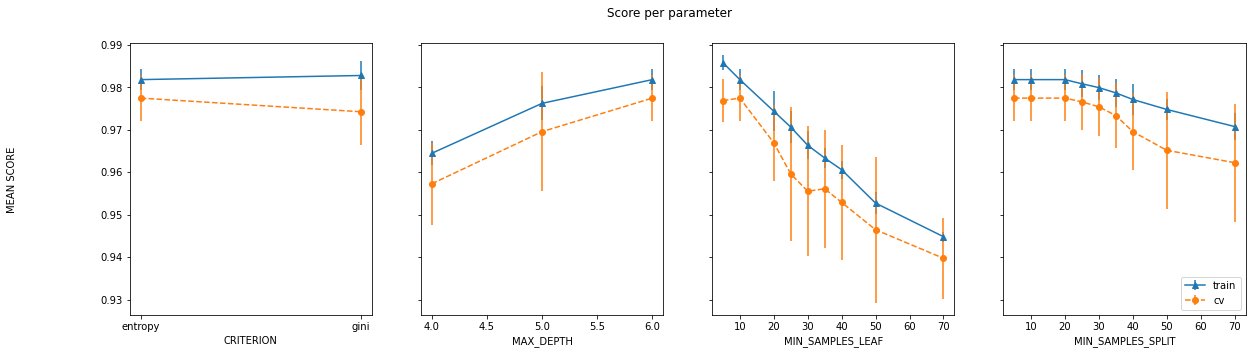

In [48]:
plot_search_results(grid_dt_class)

## Evaluation

In [49]:
print(grid_dt_class.best_params_)
print("Model best score: ", grid_dt_class.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 5}
Model best score:  0.9774793778189366


In [44]:
# Build Tuned Model
dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 6,
                               min_samples_leaf= 10,
                               min_samples_split= 5, random_state = 40
                              )
dtree.fit(OHE_train, y_train)
y_predict = dtree.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict),
           accuracy_score(y_test, y_predict))
print(report)


The evaluation report is:
Confusion Matrix:
[[241  17]
 [  6 420]]
Accuracy: 0.966374269005848



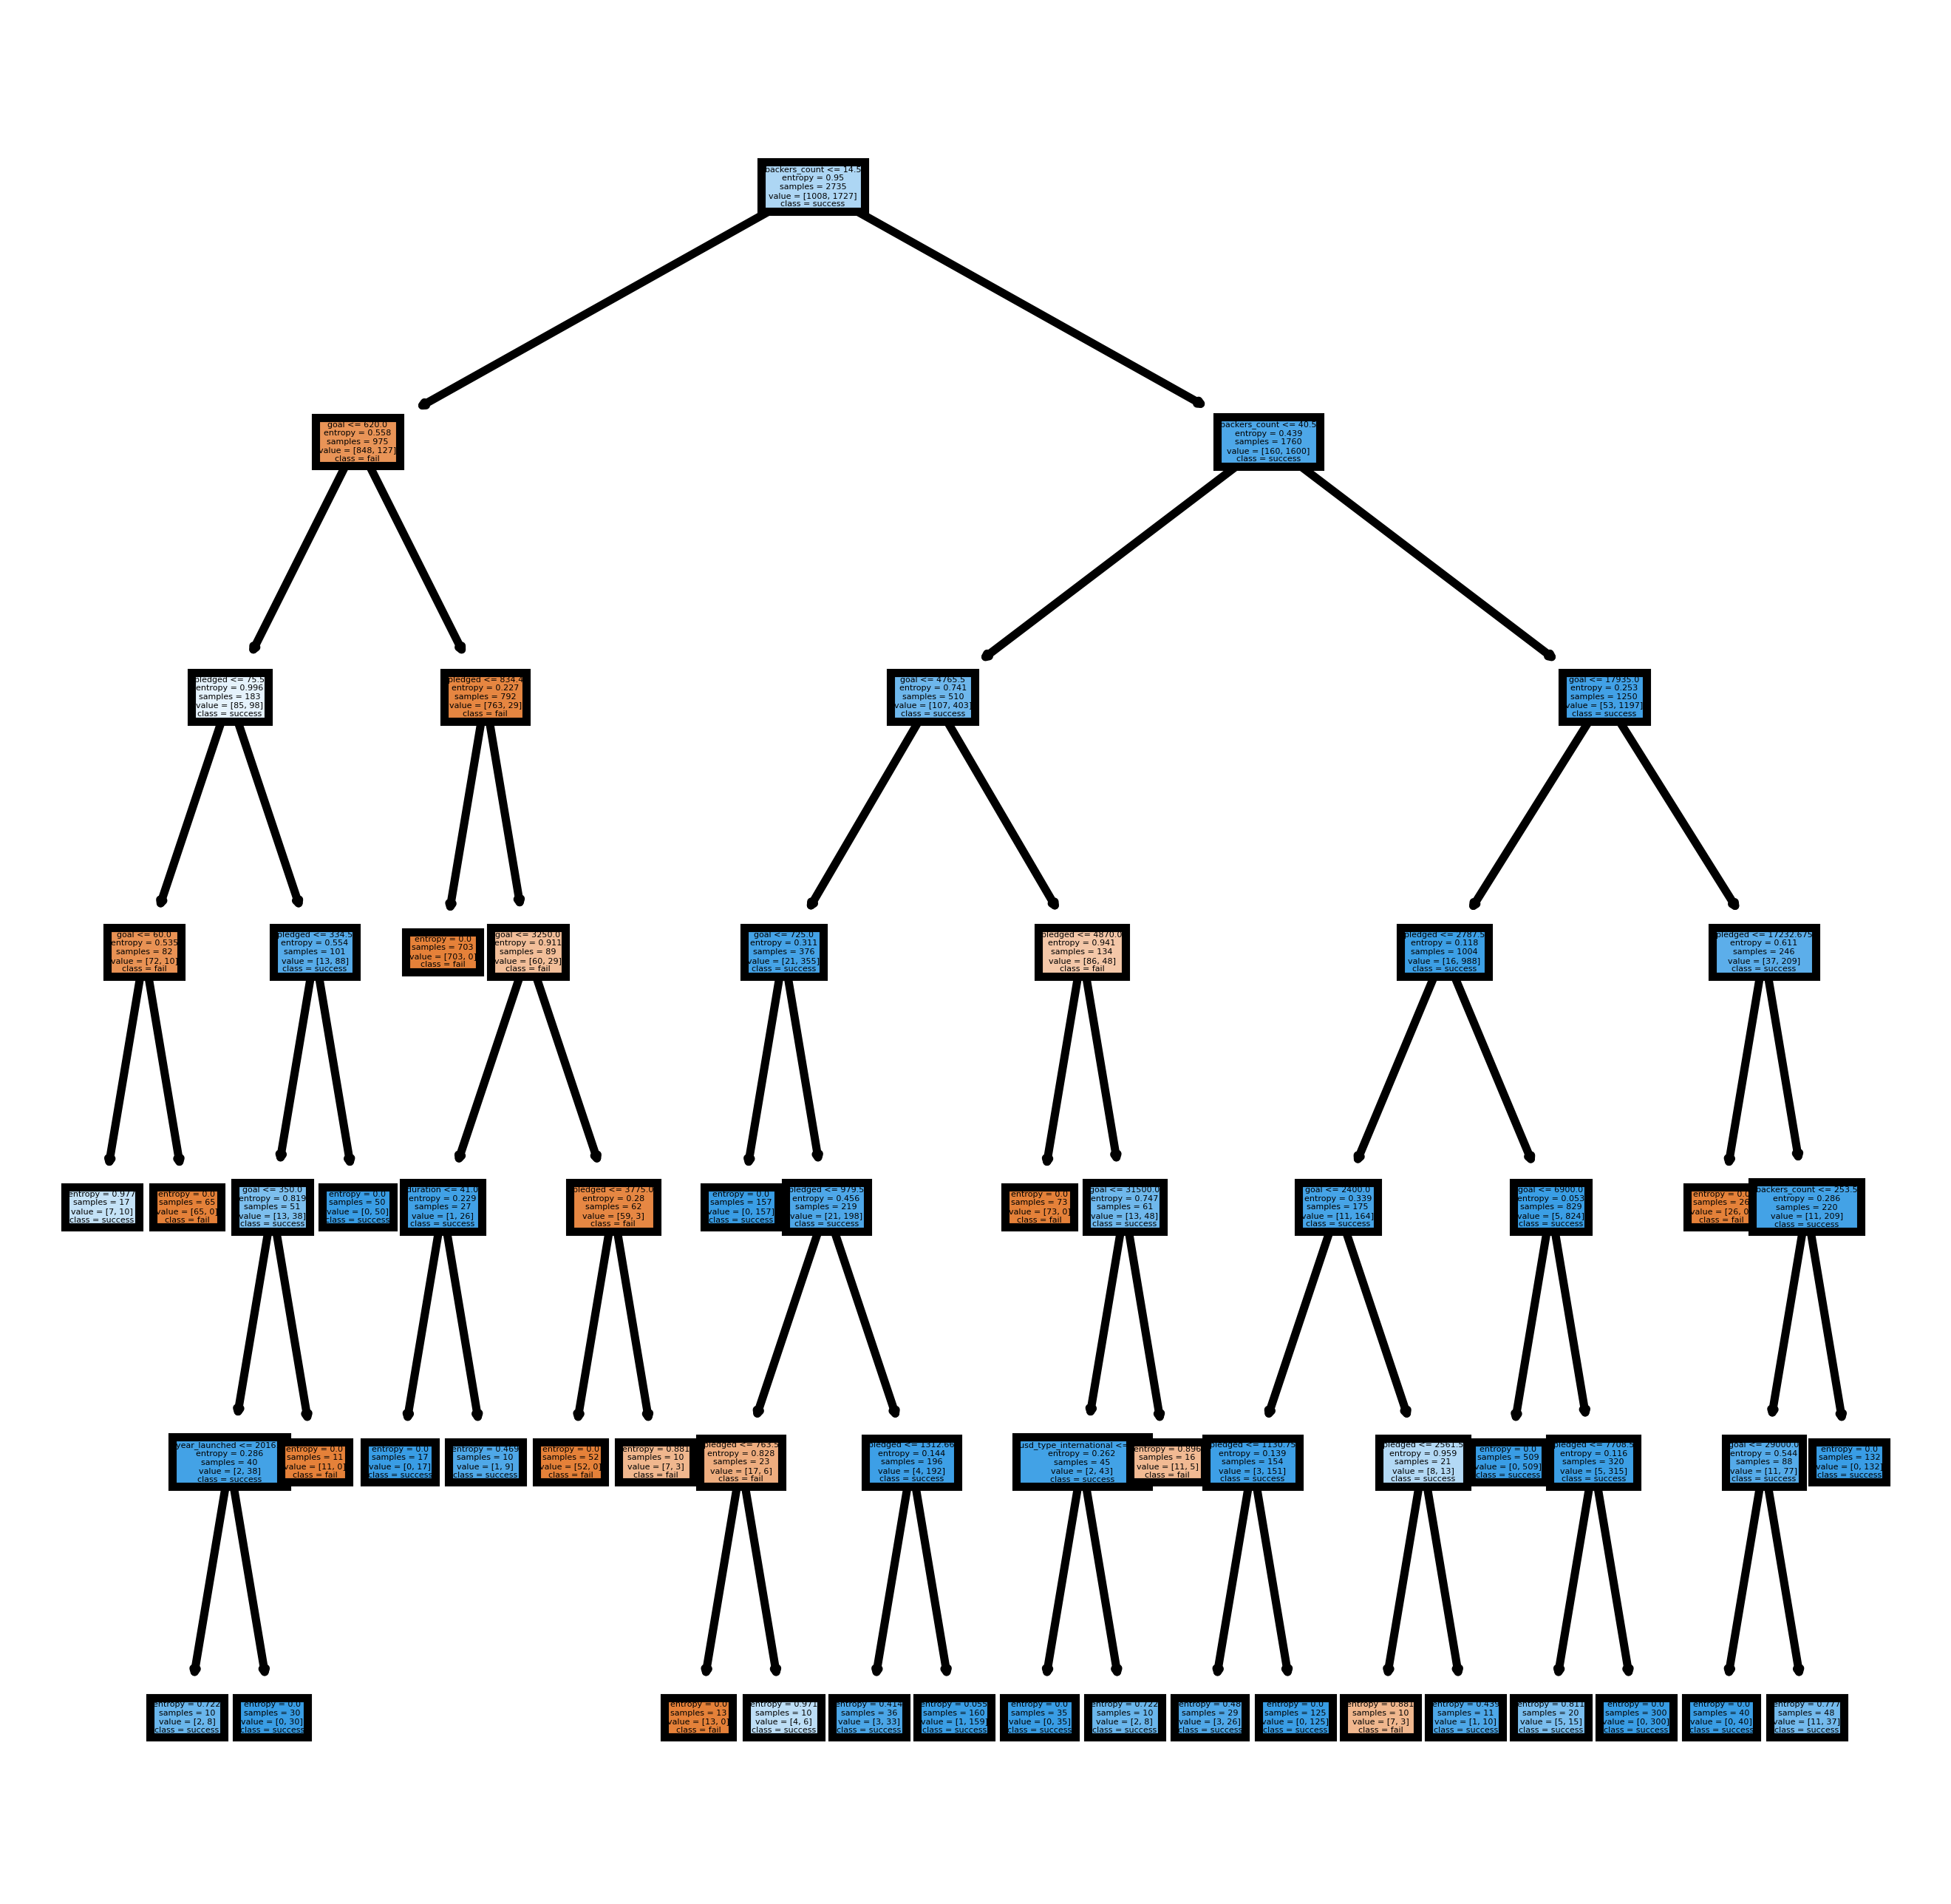

In [45]:
feature_list = list(OHE_train.columns)
cn = ['fail', 'success']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree,
               feature_names = feature_list, 
               class_names = cn,
               filled = True)
fig.savefig('dtree.png')

## Feature Importance

In [46]:
important_features_dict = {}
for idx, val in enumerate(dtree.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dtree.feature_importances_[top_idx]

print('Top 3 most important features: \n')

for i in range(3):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))


Top 3 most important features: 

1: backers_count, Score: 0.567 
2: goal, Score: 0.228 
3: pledged, Score: 0.201 
